In [3]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

# load the mnist data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

images = mnist.test.images
labels = mnist.test.labels

#print (mnist.test.images.shape)
#print (mnist.test.labels.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def sigmoid(z):
        g = 1 /(1 + np.exp(-z))
        return g

def sigmoid_gradient(z): 
        g = (np.exp(-z))/(1 + np.exp(-z))**2 
        return g

def relu(z):
        g = z * (z > 0)
        return g

def relu_gradient(z):
        g = 1 * (z > 0)
        return g     

def softmax(z):
        g = np.exp(z) / np.sum(np.exp(z), axis=0)
        return g #np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    



In [64]:
 class Network(object):
    def __init__(self, nnodes,activation_func):
        self.sizes = nnodes
        self.num_layers = len(nnodes)
        self.activation_func = activation_func
        self.biases = [np.random.randn(y,1) for y in nnodes[1:]]
        self.weights = [np.random.randn(y,x)/np.sqrt(x/2)
                        for x, y in zip(nnodes[:-1], nnodes[1:])]  #[784, 100, 50], [ 100, 50, 10 ]
        self.costs=[]  # stores the costs during training
        self.accuracies=[] # stores the accuracies during training 
        
    def feedforward(self, inputs):
        activations = []
        activations.append(inputs) 
        zs= [] 
        
        for l in range(len(self.weights)-1): #4-1 = 3
            b = self.biases[l]
            w = self.weights[l]
            z = w @ inputs + b
           
            if self.activation_func[l]=='sigmoid':
                activation = sigmoid(z)
            elif self.activation_func[l]=='relu': 
                activation = relu(z)
       
            zs.append(z) 
            activations.append(activation)
            inputs=activation  
            
        w = self.weights[-1]
        b = self.biases[-1]
        z = w @ inputs + b
        activation = softmax(z)
        activations.append(activation)
        zs.append(z)
        return activation,zs,activations
    
    def cost_function(self,minibatch):
        # computes the cross entropy cost for a single minibatch
        cost = 0;
        for n in range(len(minibatch)):
            x=minibatch[n][0]
            y=minibatch[n][1]
            prediction,dum1,dum2=self.feedforward(x)
            cost += np.sum(-(y * np.log(prediction) - (1 - y) * np.log(1 - prediction)))

        return cost 

    def Gradient_Descent(self, training_data, epoches,lr,batchsize,test_data=None):
        # training_data is a list of tuples ([x1,x2],y) where y is the class and [x1,x2] is numpy array
        # lr is the learning_rate, it is scalar
        # epochs is a scalar value for the number of times the network is going to update its parameters        
        """        
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            np.random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+batchsize]
                for k in range(0, n, batchsize)]
            for mini_batch in mini_batches:
                self.update_params(mini_batch,lr) 
                cost =self.cost_function(mini_batch)
                self.costs.append(cost/len(mini_batch))
            if test_data:
                correct = self.evaluate(test_data)
                print ("Epoch {0}: {1} / {2} Cost: {3} Accuracy: {4}".format(j, correct, n_test,cost/len(mini_batch),correct/n_test))
                self.accuracies.append(correct/n_test)
            else:
                print ("Epoch {0} complete".format(j))    
        """
        if test_data: n_test = len(test_data)
        n = len(training_data)
        
        for j in range(epochs):
            epoch_cost = 0
            np.random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+batchsize]
                for k in range(0, n, batchsize)]
            #print(len(mini_batches))
            for mini_batch in mini_batches:
                self.update_params(mini_batch,lr) 
                cost =self.cost_function(mini_batch)
                epoch_cost += (cost/len(mini_batch))
            if test_data:
                self.costs.append(epoch_cost/len(mini_batches))
                correct = self.evaluate(test_data)
                print ("Epoch {0}: {1} / {2} Cost: {3} Accuracy: {4}".format(j, correct, n_test, epoch_cost/len(mini_batches),correct/n_test))
                self.accuracies.append(correct/n_test)
            else:
                print ("Epoch {0} complete".format(j))  
        return self.costs  
  
        
    def update_params(self, minibatch, lr):
        # X is all the training data
        # X contains pairs (x,y) where x is the feature vector and y its class label
        N = len(minibatch) #batchsize
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        #print(len(grad_b))
        #print(grad_b[0].shape)
        #Gradient Descent parameter updates
        for x,y in minibatch:
            delta_grad_b, delta_grad_w = self.backprop(x, y) 
            grad_b = [nb+dnb for nb, dnb in zip(grad_b, delta_grad_b)]
            grad_w = [nw+dnw for nw, dnw in zip(grad_w, delta_grad_w)] 
    
            self.weights = [w-lr*nw/N for w, nw in zip(self.weights, grad_w)]  
            self.biases =  [b-lr*nb/N for b, nb in zip(self.biases,  grad_b)]

        
    def backprop(self, x, y):
        #Returns (grad_b, grad_w) representing the
        #gradients for the cost function  wrt b and w . 
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
        dummy,zs,activations= self.feedforward(x) #dummy is not used below 
      
        # Grad at the ouput layer 
        delta = activations[-1]- y

        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta,activations[-2].T)

        L = self.num_layers #  input layer + hidden layers + ouput layers = 4
        
        for l in range(1, L-1):
            z = zs[-l-1]
            if self.activation_func[-l]=='relu': 
                delta = np.dot(self.weights[-l].transpose(), delta) * relu_gradient(z)    
            elif self.activation_func[-l]=='sigmoid':
                delta = np.dot(self.weights[-l].transpose(), delta) * sigmoid_gradient(z)    
            # gradients of the parameters of the l-th layer
            grad_b[-l-1] = delta 
            grad_w[-l-1] = np.dot(delta, activations[-l-2].T) 
        
        #print(grad_b[2].shape)
        #print(len(grad_b))
        return (grad_b, grad_w)
    
    def evaluate(self, X):
        correct = 0
        for n in range(len(X)):
            x=X[n][0]
            y=X[n][1]
            prediction,dum1,dum2=self.feedforward(x)
            correct += int(np.argmax(y) == np.argmax(prediction))
        return correct


In [65]:
nnodes=[784,100,50,10]
learning_rate = 0.0001
epochs = 20
batch_size = 126
#tr_batch= mnist.train.next_batch(batch_size)
#training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
#training_results = [np.reshape(y,(10,1)) for y in tr_d[1]]
x, y = mnist.train.images, mnist.train.labels
x_t, y_t = mnist.test.images, mnist.test.labels
training_inputs = [np.reshape(x, (784, 1)) for x in x]
training_results = [np.reshape(y,(10,1)) for y in y]
testing_inputs = [np.reshape(x, (784, 1)) for x in x_t]
testing_results = [np.reshape(y,(10,1)) for y in y_t]
train_data = list(zip(training_inputs, training_results))
test_data = list(zip(testing_inputs, testing_results))
activation_func=['sigmoid','relu'] # use 'sigmoid' or 'relu'
nnet = Network(nnodes,activation_func)


In [66]:
nnet.Gradient_Descent(train_data,epochs,learning_rate,batch_size,test_data)

Epoch 0: 6153 / 10000 Cost: 1.275790707043728 Accuracy: 0.6153
Epoch 1: 7166 / 10000 Cost: 0.984687961575514 Accuracy: 0.7166
Epoch 2: 7788 / 10000 Cost: 0.69456366226581 Accuracy: 0.7788
Epoch 3: 7993 / 10000 Cost: 0.4562528868666425 Accuracy: 0.7993
Epoch 4: 8186 / 10000 Cost: 0.32368508768098536 Accuracy: 0.8186
Epoch 5: 8374 / 10000 Cost: 0.2549802405450448 Accuracy: 0.8374
Epoch 6: 8490 / 10000 Cost: 0.21577570133182533 Accuracy: 0.849
Epoch 7: 8587 / 10000 Cost: 0.19093756731253378 Accuracy: 0.8587
Epoch 8: 8677 / 10000 Cost: 0.17349604397948956 Accuracy: 0.8677
Epoch 9: 8743 / 10000 Cost: 0.1610764192995576 Accuracy: 0.8743
Epoch 10: 8802 / 10000 Cost: 0.1513394453178272 Accuracy: 0.8802
Epoch 11: 8842 / 10000 Cost: 0.1436559648842627 Accuracy: 0.8842
Epoch 12: 8889 / 10000 Cost: 0.1374826793122531 Accuracy: 0.8889
Epoch 13: 8906 / 10000 Cost: 0.13257590920189874 Accuracy: 0.8906
Epoch 14: 8929 / 10000 Cost: 0.12832359927341547 Accuracy: 0.8929
Epoch 15: 8958 / 10000 Cost: 0.124

[1.275790707043728,
 0.98468796157551397,
 0.69456366226581001,
 0.4562528868666425,
 0.32368508768098536,
 0.25498024054504481,
 0.21577570133182533,
 0.19093756731253378,
 0.17349604397948956,
 0.1610764192995576,
 0.1513394453178272,
 0.14365596488426269,
 0.13748267931225311,
 0.13257590920189874,
 0.12832359927341547,
 0.12467246669990051,
 0.12163305550534648,
 0.119034492838103,
 0.11686085751942654,
 0.11475404517403481]

In [68]:
cost = [1.275790707043728,
 0.98468796157551397,
 0.69456366226581001,
 0.4562528868666425,
 0.32368508768098536,
 0.25498024054504481,
 0.21577570133182533,
 0.19093756731253378,
 0.17349604397948956,
 0.1610764192995576,
 0.1513394453178272,
 0.14365596488426269,
 0.13748267931225311,
 0.13257590920189874,
 0.12832359927341547,
 0.12467246669990051,
 0.12163305550534648,
 0.119034492838103,
 0.11686085751942654,
 0.11475404517403481]

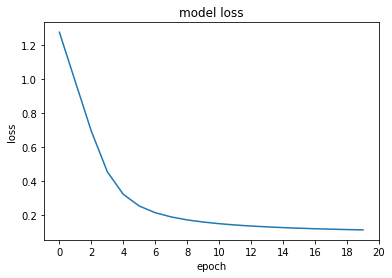

In [79]:
plt.figure()
plt.plot(cost)
plt.xticks(np.arange(0,22,2))
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()